In [1]:
import numpy as np
import os
from time import time
import datetime
import gc

from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from matplotlib import pyplot as plt


import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorboard.plugins.hparams import api as hp

from read_dataset_for_constraint import switch_dataset

from utils import plot_boundaries_hyperrect
from sTGMA import SoftTruncatedGaussianMixtureAnalysis

from black_box import BlackBoxNN
from config import  config_params, hyper_params

In [2]:
 
dataset_name = "bank_marketing"    

X_train, y_train, X_val, y_val, X_test, y_test, y_train_onehot, y_val_onehot, y_test_onehot, scaler, color_map = \
        switch_dataset(dataset_name)(if_PCA = False)

In [3]:
X_train.shape

(2636, 63)

In [4]:
black_box = tf.saved_model.load("images_cotraining/datasets/bank_marketing/components_3/value_8.0/bb_weights")

stgma = tf.saved_model.load("images_cotraining/datasets/bank_marketing/components_3/value_8.0/stgma_weights")


In [5]:
lower = stgma.lower.numpy()
upper = stgma.upper.numpy()


def binarise(lower, upper, X):
    alpha1 = np.reshape(lower, (lower.shape[0]*lower.shape[1], -1))
    alpha2 = np.reshape(upper, (upper.shape[0]*lower.shape[1], -1))
    
    X_low = (np.expand_dims(X, axis = 1) < alpha1) + 0

    X_upp = (np.expand_dims(X, axis = 1) < alpha2) + 0
    
    X_ = np.concatenate((X_low, X_upp), axis=1)
    
    return np.reshape(X_, (X_.shape[0], X_.shape[1]*X_.shape[2]))

In [6]:
X_train_exp = binarise(lower, upper, X_train)

X_test_exp = binarise(lower, upper, X_test)

bb_y_train = np.argmax(black_box.predict(X_train).numpy(), axis = -1)
bb_y_test =  np.argmax(black_box.predict(X_test).numpy(), axis = -1)

In [24]:
dt1 = DecisionTreeClassifier(max_depth = 4)

dt1.fit(X_train, y_train)

dt2 = DecisionTreeClassifier(max_depth=4)

dt2.fit(X_train_exp, y_train)

dt4 = DecisionTreeClassifier(max_depth=4)

dt4.fit(X_train, bb_y_train)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [25]:
accuracy_score(dt1.predict(X_test), y_test)

0.9211165048543689

In [26]:
accuracy_score(dt4.predict(X_test), y_test)

0.9029126213592233

In [27]:
accuracy_score(dt2.predict(X_test_exp), y_test)

0.8932038834951457

In [28]:
accuracy_score(dt2.predict(X_test_exp), bb_y_test)

0.9186893203883495

In [29]:
accuracy_score(dt4.predict(X_test), bb_y_test)

0.9526699029126213

In [23]:
accuracy_score(bb_y_test, y_test)

0.8992718446601942

[Text(279.0, 489.24, 'X[9] <= -1.045\ngini = 0.198\nsamples = 2636\nvalue = [2343, 293]'),
 Text(139.5, 380.52000000000004, 'X[1] <= -0.357\ngini = 0.493\nsamples = 348\nvalue = [194, 154]'),
 Text(69.75, 271.8, 'X[3] <= -4.781\ngini = 0.28\nsamples = 125\nvalue = [104, 21]'),
 Text(34.875, 163.08000000000004, 'X[0] <= 0.527\ngini = 0.463\nsamples = 11\nvalue = [4, 7]'),
 Text(17.4375, 54.360000000000014, 'gini = 0.0\nsamples = 6\nvalue = [0, 6]'),
 Text(52.3125, 54.360000000000014, 'gini = 0.32\nsamples = 5\nvalue = [4, 1]'),
 Text(104.625, 163.08000000000004, 'X[35] <= 0.752\ngini = 0.215\nsamples = 114\nvalue = [100, 14]'),
 Text(87.1875, 54.360000000000014, 'gini = 0.18\nsamples = 110\nvalue = [99, 11]'),
 Text(122.0625, 54.360000000000014, 'gini = 0.375\nsamples = 4\nvalue = [1, 3]'),
 Text(209.25, 271.8, 'X[3] <= -4.731\ngini = 0.481\nsamples = 223\nvalue = [90, 133]'),
 Text(174.375, 163.08000000000004, 'X[8] <= -1.575\ngini = 0.298\nsamples = 66\nvalue = [12, 54]'),
 Text(156.9

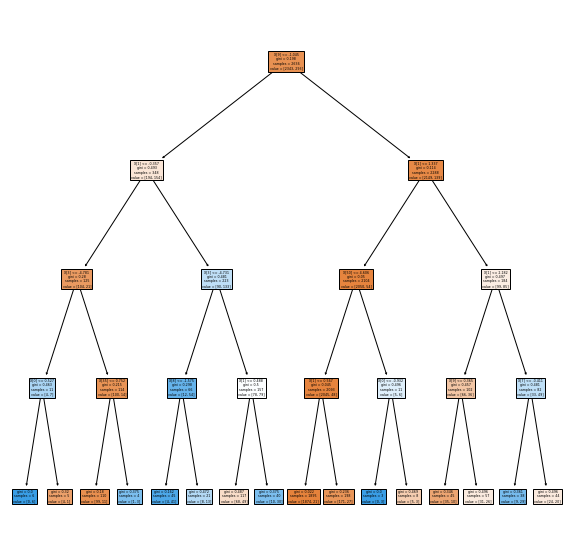

In [14]:
plot_tree(dt1, filled=True)

[Text(313.875, 489.24, 'X[3] <= 0.5\ngini = 0.198\nsamples = 2636\nvalue = [2343, 293]'),
 Text(186.0, 380.52000000000004, 'X[71] <= 0.5\ngini = 0.162\nsamples = 2525\nvalue = [2300, 225]'),
 Text(93.0, 271.8, 'X[442] <= 0.5\ngini = 0.093\nsamples = 1775\nvalue = [1688, 87]'),
 Text(46.5, 163.08000000000004, 'X[631] <= 0.5\ngini = 0.5\nsamples = 22\nvalue = [11, 11]'),
 Text(23.25, 54.360000000000014, 'gini = 0.375\nsamples = 4\nvalue = [1, 3]'),
 Text(69.75, 54.360000000000014, 'gini = 0.494\nsamples = 18\nvalue = [10, 8]'),
 Text(139.5, 163.08000000000004, 'X[242] <= 0.5\ngini = 0.083\nsamples = 1753\nvalue = [1677, 76]'),
 Text(116.25, 54.360000000000014, 'gini = 0.5\nsamples = 4\nvalue = [2, 2]'),
 Text(162.75, 54.360000000000014, 'gini = 0.081\nsamples = 1749\nvalue = [1675, 74]'),
 Text(279.0, 271.8, 'X[442] <= 0.5\ngini = 0.3\nsamples = 750\nvalue = [612, 138]'),
 Text(232.5, 163.08000000000004, 'X[746] <= 0.5\ngini = 0.245\nsamples = 7\nvalue = [1, 6]'),
 Text(209.25, 54.360000

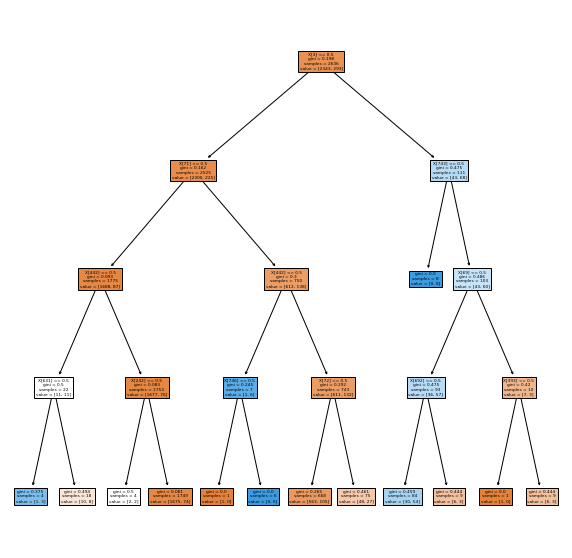

In [15]:
plot_tree(dt2, filled=True)

[Text(303.05172413793105, 489.24, 'X[9] <= -1.045\ngini = 0.175\nsamples = 2636\nvalue = [2380, 256]'),
 Text(153.93103448275863, 380.52000000000004, 'X[1] <= 0.124\ngini = 0.495\nsamples = 348\nvalue = [192, 156]'),
 Text(76.96551724137932, 271.8, 'X[3] <= -4.721\ngini = 0.445\nsamples = 239\nvalue = [159, 80]'),
 Text(38.48275862068966, 163.08000000000004, 'X[9] <= -1.55\ngini = 0.49\nsamples = 56\nvalue = [24, 32]'),
 Text(19.24137931034483, 54.360000000000014, 'gini = 0.416\nsamples = 44\nvalue = [13, 31]'),
 Text(57.72413793103449, 54.360000000000014, 'gini = 0.153\nsamples = 12\nvalue = [11, 1]'),
 Text(115.44827586206898, 163.08000000000004, 'X[7] <= 2.627\ngini = 0.387\nsamples = 183\nvalue = [135, 48]'),
 Text(96.20689655172414, 54.360000000000014, 'gini = 0.335\nsamples = 160\nvalue = [126, 34]'),
 Text(134.6896551724138, 54.360000000000014, 'gini = 0.476\nsamples = 23\nvalue = [9, 14]'),
 Text(230.89655172413796, 271.8, 'X[3] <= -2.242\ngini = 0.422\nsamples = 109\nvalue = [

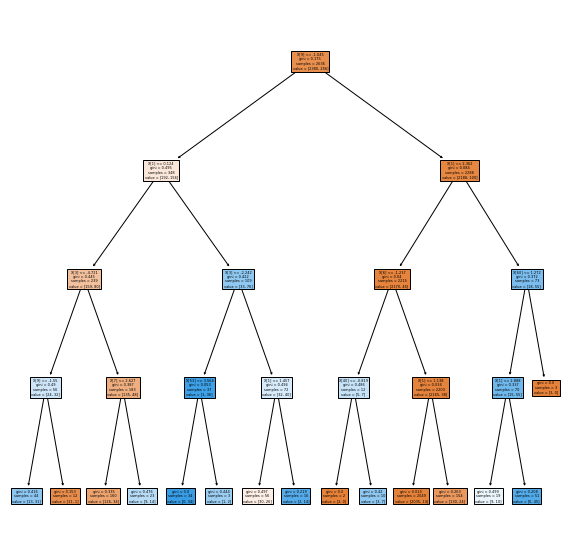

In [16]:
plot_tree(dt4, filled=True)

In [28]:
X_low = (np.expand_dims(X_train, axis = 1) < alpha1) + 0

X_upp = (np.expand_dims(X_train, axis = 1) < alpha2) + 0